In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from copy import copy, deepcopy
from scipy import special
import pandas as pd
import matplotlib as mpl
from matplotlib.colors import colorConverter
import time
import pystencils
import sympy
from lbmpy.session import *

In [2]:
# SOR iterative method with objects

# function to find final diffusion gradient with objects
def SOR_with_objects_better(N, omega, object_array, conc_mat):
    # initialise parameters
    i = 0 # iterations
    epsilon = 10 ** -5
    diff = 100000 # set to large value    

    # loop until convergence
    while diff > epsilon:
        conc_mat_old = deepcopy(conc_mat)
        conc_mat = SOR_better(conc_mat, omega, object_array)
        diff = np.amax(np.abs(conc_mat - conc_mat_old))
        i += 1
    return conc_mat

def SOR_better(conc_mat, omega, object_array):
    conc_mat[N - 1] = 1

    
    for k in range(1, N - 1):
        # left boundary 
        # if part of object, concentration is zero
        if object_array[k][0] == 1:
            conc_mat[k][0] = 0
        # otherwise: SOR equation
        else:
            conc_mat[k][0] = omega / 4 * (conc_mat[k + 1][0] + conc_mat[k - 1][0] + conc_mat[k][1] + conc_mat[k][N-1]) + (1-omega)*conc_mat[k][0]

        #right boundary
        # if part of object, concentration is zero
        if object_array[k][N - 1] == 1:
            conc_mat[k][N - 1] = 0
        # otherwise: SOR equation
        else:
            conc_mat[k][N - 1] = omega / 4 * (conc_mat[k + 1][N - 1] + conc_mat[k - 1][N - 1] + conc_mat[k][0] + conc_mat[k][N - 2]) + (1 - omega) * conc_mat[k][N - 1]

    # middle of matrix
    for j in range(N - 1):
        for i in range(1, N - 1):
            # if part of object, concentration is zero
            if object_array[i][j] == 1:
                conc_mat[i][j] = 0
            # otherwise: SOR equation
            else:
                conc_mat[i][j] = (omega / 4) * (conc_mat[i + 1][j] + conc_mat[i - 1][j] + conc_mat[i][j + 1] + conc_mat[i][j - 1]) + (1 - omega) * conc_mat[i][j]
                if conc_mat[i][j] < 0:
                    conc_mat[i][j] = 0

    
    return conc_mat

In [3]:
# SOR iterative method with objects

# function to find final diffusion gradient with objects
def SOR_with_objects(N, omega, object_array, conc_mat):
    def SOR(conc_mat, omega):
        conc_mat[N - 1] = 1
        
        # left boundary
        for k in range(1,N-1):
            # if part of object, concentration is zero
            if object_array[k][0] == 1:
                    conc_mat[k][0] = 0
            
            # otherwise: SOR equation
            else:
                conc_mat[k][0] = omega / 4 * (conc_mat[k + 1][0] + conc_mat[k - 1][0] + conc_mat[k][1] + conc_mat[k][N-1]) + (1-omega)*conc_mat[k][0]
        
        # middle of matrix
        for j in range(N-1):
            for i in range(1,N-1):
                # if part of object, concentration is zero
                if object_array[i][j] == 1:
                    conc_mat[i][j] = 0

                # otherwise: SOR equation
                else:
                    conc_mat[i][j] = (omega/4)*(conc_mat[i+1][j] + conc_mat[i-1][j] + conc_mat[i][j+1] + conc_mat[i][j-1]) + (1-omega)*conc_mat[i][j]
                    if conc_mat[i][j] < 0:
                        conc_mat[i][j] = 0
        # right boundary
        for k in range(1,N-1):
            # if part of object, concentration is zero
            if object_array[k][N-1] == 1:
                conc_mat[k][N-1] = 0
            
            # otherwise: SOR equation
            else:
                conc_mat[k][N-1] = omega/4*(conc_mat[k+1][N-1] + conc_mat[k-1][N-1] + conc_mat[k][0] + conc_mat[k][N-2]) + (1-omega)*conc_mat[k][N-1]

        return conc_mat

    # initialise parameters
    i = 0 # iterations
    epsilon = 10**-5
    diff = 100000 # set to large value    

    # loop until convergence
    while diff > epsilon:
        conc_mat_old = deepcopy(conc_mat)
        conc_mat = SOR(conc_mat,omega)
        diff = np.amax(np.abs(conc_mat - conc_mat_old))
        i += 1
    return diff, i,conc_mat,conc_mat_old

In [4]:
# SOR iterative method with objects - accelerated using multiple threads

import threading
import multiprocessing
import time


class SunlightThreads(threading.Thread):
    """
        Class that handles a single thread for computing the sunlight diffusion
    """
    
    def __init__(self, index, n_threads, omega, object_array, conc_mat, result):
        """
            Constructor for the SunlightThreads class.
            
            Parameters:
              - index: The index of the array as the whole, used for correctly
                ordering the results and such
              - n_threads: The number of threads that are working on this problem
              - omega: constant used in the SOR-method to try and let the diffusal
                algorithm converge more quickly
              - object_array: A square array consisting of 1's and 0's,
                denoting where the coral lives.
              - conc_mat: A square array that carries the diffusion state at
                the current timestep.
              - result: The resulting array. Must be different than conc_mat to
                avoid race conditions and junk.
            
            Returns:
            Nothing lmao
        """
        
        # Call the parent constructor so we do thread initialization and junk
        threading.Thread.__init__(self)
        # Set the thread to a daemon so that it stops when the main thread stops
        self.daemon = True
        
        # Set the given parameters internally
        self.index = index
        self.n_threads = n_threads
        self.omega = omega
        self.object_array = object_array
        self.conc_mat = conc_mat
        self.result = result
        
        # And some properties to keep track of the thread's progress
        self.processed = 0
        self.running = False
        self.enabled = False
    
    def run(self):
        """
            Function that is ran on the thread itself.
            In this case, computes its share of the next diffusion timestep.
        """
        
        # Do the work loop
        self.running = True
        self.enabled = True
        while self.enabled:
            ### Step 1: Compute the left boundry
            # First, compute the workload boundries
            N_left = self.result.shape[0] - 2
            work_size = int(N_left / self.n_threads + 1.0)
            start = 1 + self.index * work_size
            stop = min(start + work_size, 1 + N_left)

            # Do the left boundry job
            for y in range(start, stop):
                if self.object_array[y][0] == 1:
                    # It's part of the coral, so there can't be light here
                    self.result[y][0] = 0
                else:
                    self.result[y][0] = self.omega / 4 * (self.conc_mat[y + 1][0] + self.conc_mat[y - 1][0] + self.conc_mat[y][1] + self.conc_mat[y][N - 1]) + \
                        (1 - self.omega) * self.conc_mat[y][0]
                
                print("H-Hewwo?")
                
                # Keep track of how many we did
                self.processed += 1



            ### Step 2: Compute the middle bit
            # Compute the workload boundries again
            N_middle = self.result.shape[0] - 2
            work_size = int((N_middle**2) / self.n_threads + 1.0)
            start = self.index * work_size
            stop = min(start + work_size, N_middle**2)

            # Do the middle boundry job
            for i in range(start, stop):
                # Split the i into a valid x and y
                x = 1 + i  % N
                y = 1 + i // N

                if self.object_array[y][0] == 1:
                    # It's part of the coral, so there can't be light here
                    self.result[y][0] = 0
                else:
                    # Do the SOR formula yay
                    self.result[y][x] = (self.omega / 4) * (self.conc_mat[y + 1][x] + self.conc_mat[y - 1][x] + self.conc_mat[y][x + 1] + self.conc_mat[y][x - 1]) + \
                                            (1 - self.omega) * self.conc_mat[y][x]
                    if self.result[y][x] < 0:
                        self.result[y][x] = 0
                
                print("H-Hewwo? O.O")
                
                # Keep track of how many we did
                self.processed += 1



            ### Step 3: Compute the right part of the array
            # Compute the workload boundries again
            N_right = self.result.shape[0] - 2
            work_size = int(N_right / self.n_threads + 1.0)
            start = self.index * work_size
            stop = min(start + work_size, N_right)

            # Do the right boundry job
            for y in range(start, stop):
                if self.object_array[y][0] == 1:
                    # It's part of the coral, so there can't be light here
                    self.result[y][0] = 0
                else:
                    self.result[y][N - 1] = self.omega / 4 * (self.conc_mat[y + 1][N - 1] + self.conc_mat[y - 1][N - 1] + self.conc_mat[y][0] + self.conc_mat[y][N - 2]) + \
                        (1 - self.omega) * self.conc_mat[y][N - 1]
                
                print("H-Hewwo? ^.^")
                
                # Keep track of how many we did
                self.processed += 1
            
            
            
            ### Step 4: Synchronize
            # Haha pranked
            self.running = False
            self.enabled = False



def SOR_with_objects_mt_launch(N, omega, object_array, conc_mat, n_threads = 0.5):
    """
        Function to find the final diffusion gradient with objects, using
        multiple threads. Does not wait until all threads have executed.

        Parameters:
          - N: the size of the matrices
          - omega: constant used in the SOR-method to try and let the diffusal
            algorithm converge more quickly
          - object_array: N x N matrix consisting of 1's and 0's, denoting
            where the coral lives
          - conc_mat: N x N matrix that contains the previous diffusal state
            of the sunlight
          - n_threads: the number of threads to run. If a floating point, then
            n_threads describes a portion of all hardware threads available. If
            an integer, then it denotes an absolute number of threads.
            Note: this function always rounds the ratio of threads UP.
            (Default: 0.5, i.e., half of all threads)

        Result:
        A list consisting of the Thread objects. Use
        SOR_with_objects_mt_async_wait() to retrieve the answer from them.
    """

    # First, resolve the number of threads
    if type(n_threads) == float:
        # Fetch the number of hw threads
        n_hw_threads = multiprocessing.cpu_count()

        # Get the ratio of threads for this function. Note that this one rounds
        #   UP, to always fill threads when used with the diffusal algorithm.
        n_threads = int(n_hw_threads * n_threads)
    elif type(n_threads) != int:
        raise TypeError("Hello there!")

    # Initialise parameters
    i = 0
    # Number of iterations
    epsilon = 10**-5
    # Set to large value 
    diff = 100000 

    # Loop until convergence
    while diff > epsilon:
        # Launch the worker threads
        threads = []
        print(conc_mat.shape)
        result = np.zeros(conc_mat.shape)
        for j in range(n_threads):
            threads.append(SunlightThreads(j, n_threads, omega, object_array, conc_mat, result))

        # Launch the threads to compute a single SOR
        conc_mat_old = conc_mat.copy()
        for j in range(n_threads):
            threads[j].start()

        # Wait for all threads to finish
        for j in range(n_threads):
            while threads[j].enabled:
                time.sleep(0.1)
                pass

        # Compute the difference and then we're done with this SOR iteration
        diff = np.amax(np.abs(conc_mat - conc_mat_old))
        i += 1
    
    # We're done, return the result
    return conc_mat



# def SOR_with_objects_mt(N, omega, object_array, conc_mat, n_threads = 0.5):
#     """
#         Function to find the final diffusion gradient with objects, using
#         multiple threads
        
#         Parameters:
#           - N: the size of the matrices
#           - omega: constant used in the SOR-method to try and let the diffusal
#             algorithm converge more quickly
#           - object_array: N x N matrix consisting of 1's and 0's, denoting
#             where the coral lives
#           - conc_mat: N x N matrix that contains the previous diffusal state
#             of the sunlight
#           - n_threads: the number of threads to run. If a floating point, then
#             n_threads describes a portion of all hardware threads available. If
#             an integer, then it denotes an absolute number of threads.
#             Note: this function always rounds the ratio of threads UP.
#             (Default: 0.5, i.e., half of all threads)
        
#         Result:
#         An N x N matrix describing the sunlight concentrations at the next
#         timestep.
#     """
    
#     # Call the async launcher, immediately waiting for its result, and we're done
#     return SOR_with_objects_mt_wait(
#         SOR_with_objects_mt_launch(
#             N,
#             omega,
#             object_array,
#             conc_mat,
#             n_threads=n_threads
#         )
#     )

In [5]:
# SOR iterative method with objects - accelerated using CUDA
from numba import cuda, float32

@cuda.jit
def SOR_kernel(result, conc_mat, object_array, omega, epsilon, max_iter):
    """
        The kernel executed on the GPU. Computes the diffusion of a single
        timestep, contuining until the algorithm converged. Note that the
        algorithm actually checks local convergence; however, with an eta that
        is small enough this shouldn't cause huge differences.
        
        Parameters:
          - result: The N x N matrix that will contain the diffusion gradient
            at the next timestep
          - conc_mat: The N x N matrix that contains the diffusion
            concentrations at the current timestep
          - object_array: An N x N matrix that describes where the coral is
            with 1's and 0's
          - omega: Constant used in SOR to let the algorithm converge faster.
          - epsilon: The maximum difference between two timesteps before we say
            the algorithm converged
          - max_iter: Maximum number of convergence iterations we do
        
        Returns:
        nothing
    """
    
    # First, define a shared array among this block
    diffs = cuda.shared.array(32, dtype=float32)
    
    # Fetch the size of the area we work on
    N = conc_mat.shape[1]
    rows = N - 2
    cols = N
    
    # Compute the 2D index of this thread
    block_i = cuda.threadIdx.x
    i = block_i + cuda.blockIdx.x * cuda.blockDim.x
    x, y = i % cols, 1 + i // cols
    
    # If x and y are outside our interested area, quit
    if x >= cols or y >= 1 + rows:
        return
    
    # If within bounds, then compute the x-coordinates of the left and right neighbours of this cell
    lx, rx = x - 1, x + 1
    if lx < 0:
        lx = N - 1
    if rx > N - 1:
        rx = 0
    
    # Keep looping until we converge
    this_timestep = conc_mat
    next_timestep = result
    i = 0
    for i in range(max_iter):
        # Compute the new value from the old one (but only if not a coral block)
        new, old = 0, this_timestep[y, x]
        if object_array[y, x] != 1:
            # Get the average value of all four neighbours
            avg_conc = 1/4 * (this_timestep[y + 1, x] + this_timestep[y - 1, x] + this_timestep[y, rx] + this_timestep[y, lx])

            # Update the current cell using the SOR formula
            new = max(0, omega * avg_conc + (1 - omega) * old)
            if new < 0: new = 0

        # Update the result and the difference
        next_timestep[y, x] = new
        diffs[block_i] = abs(new - old)
        
        # Since we're done, swap the pointers for the matrices
        temp = this_timestep
        this_timestep = next_timestep
        next_timestep = temp

        # Wait until the other threads in this block reached this point too
        cuda.syncthreads()

        # Bit double work, but search the diffs for the maximum diff. If that's lower than epsilon, we're done
        max_diff = 0
        for diff in diffs:
            if diff > max_diff:
                max_diff = diff
        if max_diff < epsilon:
            break
        
        # Otherwise, sync again before the next iteration. Note that this shouldn't cause any deadlocks, as all threads within a block should obtain the same max_diff.
        cuda.syncthreads()
    
    # If we're done but we last wrote to conc_mat, then copy the results to conc_mat
    if i % 2 == 0:
        result[y, x] = conc_mat[y, x]



def SOR_with_objects_cuda(N, omega, object_array, conc_mat, block_size = 32, max_iter = 100):
    """
        Function to find the final diffusion gradient with objects, using
        the GPU as accelerator.

        Parameters:
          - N: the size of the matrices
          - omega: constant used in the SOR-method to try and let the diffusal
            algorithm converge more quickly
          - object_array: N x N matrix consisting of 1's and 0's, denoting
            where the coral lives
          - conc_mat: N x N matrix that contains the previous diffusal state
            of the sunlight
          - block_size: number of threads per CUDA warp (Default: 32)
          - max_iter: Maximum number of iterations before we always call the
            algorithm converged (Default: 100)

        Result:
        An N x N matrix that describes the diffusion at the next timestep.
    """
    
    # First, check if we have access to a CUDA GPU
    if len(cuda.gpus) == 0:
        raise RuntimeError("No CUDA-capable GPUs detected")
    
    # We set the top row of the new convergence to be 1's
    result = np.zeros(conc_mat.shape, dtype=float)
    for x in range(N):
        result[N - 1, x] = 1
    
    # With the GPU available, prepare the arrays to send to the gpu
    gpu_object_array = cuda.to_device(object_array)
    gpu_conc_mat = cuda.to_device(conc_mat)
    gpu_result = cuda.to_device(result)
    
    # Next, compute the number of blocks needed
    n_blocks = int(math.ceil((N * (N - 2)) / block_size))
    
    # Finally, call the kernel
    epsilon = 10**-5
    SOR_kernel[n_blocks, block_size](gpu_result, gpu_conc_mat, gpu_object_array, omega, epsilon, max_iter)
    
    # Once done, retrieve the result
    result = gpu_result.copy_to_host()
    
    # Done, return it!
    return result

In [9]:
import math

# function to find the neighbours of a new object cell, add to set (so all candidates are unique) 
def get_candidates_SOR(object_loc,object_array,candidates):
    # check if north, south,east, west neighbours are NOT part of object, and add them to candidates
    if object_loc[1]!=N-1 and object_array[object_loc[0]][object_loc[1]+1] == 0:
        candidates.add((object_loc[0],object_loc[1]+1))
    if object_loc[1]!=0 and object_array[object_loc[0]][object_loc[1]-1] == 0:
        candidates.add((object_loc[0],object_loc[1]-1))
    if object_loc[0]!=N-1 and object_array[object_loc[0]+1][object_loc[1]] == 0:
        candidates.add((object_loc[0]+1,object_loc[1]))
    if object_loc[0]!=0 and object_array[object_loc[0]-1][object_loc[1]] == 0:
        candidates.add((object_loc[0]-1,object_loc[1]))

    return candidates

# function to calculate the SOR of a grid with object, until convergence, with growing object
def SOR_DLA_to_solution(N,eta,omega,iterations):
    # calculate the analytic solution at t=1
    t = 1
    analytic_sol = lambda x, D, t: sum([scipy.special.erfc((1-x+2*i)/(2*np.sqrt(D*t))) - scipy.special.erfc((1+x+2*i)/(2*np.sqrt(D*t))) for i in range(10000)])
    x = np.arange(0, 1, 1 / N)
    analytic_matrix = analytic_sol(x, 1, t)
    seed_coor_y = int(N / 2)

    # initialise start diffusion gradient as the analytic solution
    conc_mat = np.zeros((N,N))
    for i in range(N):
        conc_mat[i] = analytic_matrix[i]

    # source top boundary
    conc_mat[N-1] = 1

    # initalisation of array with seed of object
    object_array = np.zeros((N, N))
    object_array[0, seed_coor_y] = 1
    candidates = set()
    candidates = get_candidates_SOR((0, seed_coor_y), object_array, candidates)
    
    # first SOR 
#     conc_mat = SOR_with_objects(N,omega,object_array,conc_mat)
    conc_mat = SOR_with_objects_cuda(N, 1.0, object_array, conc_mat, block_size = 32)
  
    # keep track of iterations needed
    totaliterations = 0
    
    # loop until object is grown 'iterations' times, finding SOR with each growth
    st_times = []
    mt_times = []
    conc_mat_st = conc_mat.copy()
    conc_mat_mt = conc_mat.copy()
    object_array_st = object_array.copy()
    object_array_mt = object_array.copy()
    candidates_st = candidates.copy()
    candidates_mt = candidates.copy()
    for k in range(iterations):
#         print(f"Iter {k + 1}/{iterations}")
        for y in range(conc_mat_mt.shape[0]):
            for x in range(conc_mat_mt.shape[1]):
                if math.isnan(conc_mat_mt[y, x]):
                    print(f"Found NaN @ ({x}, {y})")
                if math.isinf(conc_mat_mt[y, x]):
                    print(f"Found inf @ ({x}, {y})")
        object_array_st,conc_mat_st, candidates_st = choose_growth(N,eta,conc_mat_st, candidates_st, object_array_st)
        object_array_mt,conc_mat_mt, candidates_mt = choose_growth(N,eta,conc_mat_mt, candidates_mt, object_array_mt)
            
#         # First, compute with threads
# #         print("Start mt...")
#         mt_start = time.time()
#         conc_mat_mt = SOR_with_objects_mt(N, 1.0, object_array_mt, conc_mat_mt, n_threads = 16)
#         mt_times.append(time.time() - mt_start)
#         print("   Done")
        
        # Compute with CUDA!
#         print("Start cuda...")
        mt_start = time.time()
        conc_mat_mt = SOR_with_objects_cuda(N, 1.0, object_array_mt, conc_mat_mt, block_size = 32)
        mt_times.append(time.time() - mt_start)
#         print("   Done")
    
        # Next, get the same result with the naive implementation
#         print("Start st...")
#         conc_mat_old = conc_mat.copy()
#         st_start = time.time()
#         conc_mat_st = SOR_with_objects(N, omega, object_array_st, conc_mat_st)
#         st_times.append(time.time() - st_start)
#         print("   Done")
        # Compare them
#         errored = False
#         for y in range(conc_mat_mt.shape[0]):
#             for x in range(conc_mat_mt.shape[1]):
#                 if abs(conc_mat_st[y][x] - conc_mat_mt[y][x]) > 1e-3:
#                     errored = True
#                     print(f"WARNING: Difference detected @ ({x}, {y}) (expected {conc_mat_st[y][x]}, got {conc_mat_mt[y][x]})")
#         if errored:
#             return None, None, None, None
        
        # Do normal stuff blabla
#         difference, i, conc_mat, concold = SOR_with_objects(N,omega,object_array,conc_mat)
        totaliterations += i
#         break

    # When done, plot
    plt.title("SOR runtime per timestep")
    plt.xlabel("Timestep")
    plt.ylabel("Runtime (s)")
    plt.yscale("log")
#     plt.plot(range(iterations), st_times, label="Single-threaded")
    plt.plot(range(iterations), mt_times, label="Multi-threaded")
    plt.legend()
    plt.show()
    
#     # Also plot the speedup
#     plt.title("CUDA speedup per timestep")
#     plt.xlabel("Timestep")
#     plt.ylabel("Speedup")
#     plt.plot(range(iterations), [st_times[i] / mt_times[i] for i in range(iterations)])
#     plt.show()

#     plt.imshow(conc_mat_st,origin='lower',extent=[0,1,0,1],cmap='Spectral')
#     plt.imshow(conc_mat_mt,origin='lower',extent=[0,1,0,1],cmap='Spectral')
    return conc_mat_st,conc_mat_mt,object_array_st,object_array_mt, totaliterations, object_array
    
def choose_growth(N,eta,conc_mat, candidates, object_array):

    # calculate the probabilities of growth for each candidate
    probs = []
    total = np.sum([conc_mat[cand]**eta for cand in candidates])
    if total == 0:
        # Assign uniform probability
        probs = [1/len(candidates) for i in range(len(candidates))]
    else:
        for i in candidates:
            prob = (conc_mat[i]**eta)/total
            probs.append(prob)

    # choose one and grow
    list_candidates = list(candidates)
    chosengrowth = list_candidates[np.random.choice(len(candidates),p=probs)]
    object_array[chosengrowth] = 1
    candidates = get_candidates_SOR(chosengrowth, object_array, candidates)
    conc_mat[chosengrowth] = 0

    return object_array,conc_mat, candidates
    


In [10]:
# function to make a combined imshow plot, where the object is visible along with the gradient

## code (with small adjustments) based on answer at: https://stackoverflow.com/questions/10127284/overlay-imshow-plots-in-matplotlib
def plot_object_gradient(conc_mat, object_array,eta):
    # generate the colors for your colormap
    color1 = colorConverter.to_rgba('white')
    color2 = colorConverter.to_rgba('black')

    # make the colormaps
    cmap2 = mpl.colors.LinearSegmentedColormap.from_list('my_cmap2',[color1,color2],256)
    cmap2._init() # create the _lut array, with rgba values

    # create your alpha array and fill the colormap with them.
    # here it is progressive, but you can create whathever you want
    alphas = np.linspace(0, 0.8, cmap2.N+3)
    cmap2._lut[:,-1] = alphas

    img2 = plt.imshow(conc_mat, interpolation='nearest', cmap='Spectral', origin='lower', extent=[0,1,0,1])
    plt.colorbar()
    img3 = plt.imshow(object_array, interpolation='nearest', cmap=cmap2, origin='lower', extent=[0,1,0,1])

    plt.title(f"Object with gradient, eta = {eta}")

    
    plt.show()

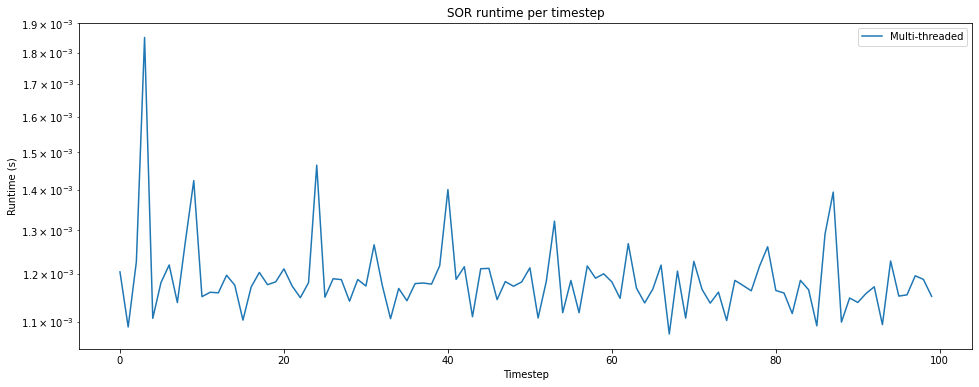

1.19s


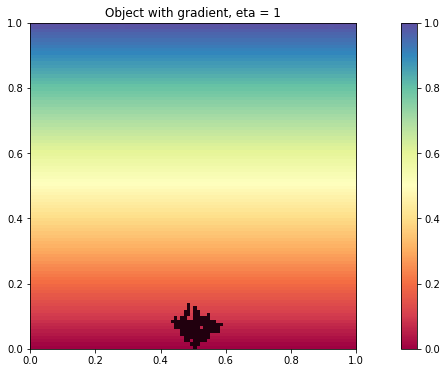

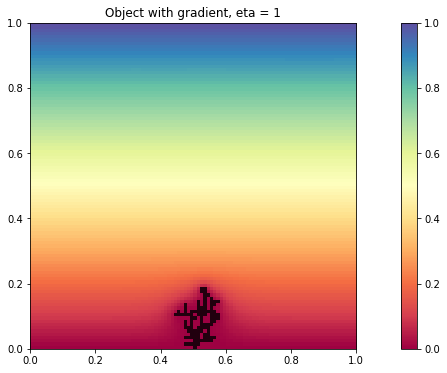

In [11]:
# test run

# initialise parameters
N = 100
eta = 1 
omega = 1.5
iterations = 100

now = time.time()
conc_mat_st,conc_mat_mt, object_array_st, object_array_mt, totaliterations, object_array = SOR_DLA_to_solution(N,eta,omega,iterations)
print(f"{time.time() - now:.2f}s")
plot_object_gradient(conc_mat_st, object_array_st, 1)
plot_object_gradient(conc_mat_mt, object_array_mt, 1)

In [ ]:
import pystencils
import sympy
from lbmpy.session import *
# example lid driven cavity
ldc = create_lid_driven_cavity(domain_size=(100, 40), method='srt', relaxation_rate=1.6)

ldc.run(500)
plt.figure(dpi=200)
#plt.vector_field(ldc.velocity_slice());

plt.scalar_field(ldc.velocity[:, :, 0])

In [ ]:
scenario = create_channel(domain_size=(100,100), force=1e-4,duct=True, method='srt', relaxation_rate=1.9)
#flag = scenario.boundary_handling.set_boundary(NoSlip(), make_slice[0.3:0.4, 0.0:0.3])
#print(np.where(object_array==1))


for j in range(N-1):
    for i in range(1,N-1):
        # if part of object, concentration is zero
            if object_array[i][j] == 1:
                flag = scenario.boundary_handling.set_boundary(NoSlip(), make_slice[j,i])
scenario.run(500)

plt.figure()
plt.scalar_field(scenario.velocity[:,:,0])
# plt.vector_field(scenario.velocity_slice());

In [ ]:
import math

# The threshold which the pressure needs to reach before the coral breaks (disappears)
THRESHOLD = 0.005

def coral_breaky_breaky(seed_coord_x, coral_matrix, vector_field, copy=True):
    """
        Function that computes if the coral is gonna breaky breaky
        
        Parameters:
          - seed_coord_x: the x-coordinate of the seed of the coral (the y is
            assumed to be 0)
          - coral_matrix: a numpy array of 0's and 1's that determine where
            the coral is
          - vector_field: (I assume?) een numpy array of 2D vectors
          - copy: If True, does not modify the original object but instead returns a new one
          
        Returns:
          - The coral matrix with the relevant pixels removed
          
        O.O does it work?
    """
    
    # Copy the matrix if the user so desires
    if copy:
        coral_matrix = coral_matrix.copy()
        
    # Loop through the coral matrix to find the corals
    for y in range(len(coral_matrix)):
        for x in range(len(coral_matrix[y])):
            if (x == seed_coord_x and y == 0) or coral_matrix[y][x] == 0: continue

            # Compute the pressure at this point (i.e., length of the vector)
            pressure = math.sqrt(vector_field[x, y][0] ** 2 + vector_field[x, y][1] ** 2)

            # If the pressure exceeds the threshold, remove the coral (:()
            if pressure > THRESHOLD:
                coral_matrix[y][x] = 0

    # We're done! Return the result
    return coral_matrix

In [ ]:
def coral_painty_painty(seed_coord_x, coral_matrix, copy=True):
    """
        Function that checks which pixels are still connected to the source,
        and removes them. Also returns a new list of potential growth
        candidates.
        
        Note: We assume that a diagonal connection == no connection
        
        Parameters:
          - seed_coord_x: the x-coordinate of the seed of the coral (the y is
            assumed to be 0)
          - coral_matrix: a numpy array of 0's and 1's that determine where
            the coral is
          - copy: If True, does not modify the original object but instead returns a new one
        
        Returns:
        A tuple of:
          - The coral matrix, with all the unconnected pixels removed
          - A new list of growth candidates
    """
    
    # Copy the matrix if the user so desires
    if copy:
        coral_matrix = coral_matrix.copy()
        
    # Do a breadth-first search starting at the seed to see which pixels are connected to the seed
    coral_matrix[0][seed_coord_x] = 2
    to_do = [(seed_coord_x, 0)]
    candidates = set()
    while len(to_do) > 0:
        # Fetch the pixel to check
        x, y = to_do[0]
        to_do = to_do[1:]
        
        # Get the area around the pixel
        for neighbour in [(-1, 0), (0, 1), (1, 0), (0, -1)]:
            nx = x + neighbour[0]
            ny = y + neighbour[1]
            
            # Skip if the pixel is out-of-bounds
            if nx < 0 or nx > coral_matrix.shape[0] - 1 or ny < 0 or ny > coral_matrix.shape[1] - 1:
                continue
            
            # If the pixel is not a pixel, then store it as possible growth candidate
            if coral_matrix[ny][nx] == 0:
                # Uncomment for the correct candidates order
#                 candidates.add((nx, ny))
                candidates.add((ny, nx))
            
            # If it is an (unvisited) pixel, then mark as visited/connected and add it to the todo list
            if coral_matrix[ny][nx] == 1:
                # Mark the pixel as connected
                coral_matrix[ny][nx] = 2
                
                # Add to the queue
                to_do.append((nx, ny))
    
    # Go thru the matrix again and remove anything that's a 1
    coral_matrix[coral_matrix == 1] = 0
    # Convert the visited pixels back to 1's
    coral_matrix[coral_matrix == 2] = 1
    
    # Done!
    return coral_matrix, candidates

In [ ]:
def coral_density(seed_coord_x, coral_matrix):
    """
        Function that computes the average distance per pixel to the source
        for the entire coral.
        
        Parameters:
          - seed_coord_x: the x-coordinate of the seed of the coral (the y is
            assumed to be 0)
          - coral_matrix: a numpy array of 0's and 1's that determine where
            the coral is
        
        Returns:
        The average distance of the coral. The lower, the denser.
    """
    
    # Search through the coral
    total_distance = 0
    n_pixels = 0
    for y in range(len(coral_matrix)):
        for x in range(len(coral_matrix[y])):
            # If not a coral or the source block, then skip
            if (x == seed_coord_x and y == 0) or coral_matrix[y][x] != 1: continue

            # If coral, then compute the distance to the source block
            total_distance += math.sqrt((x - seed_coord_x)**2 + y**2)
            n_pixels += 1

    # To return the average distance, we return total / count
    return total_distance / n_pixels

In [ ]:
print(object_array[object_array>=1].shape)

In [ ]:
object_array_test = object_array.copy()
object_array_test[20, 20] = 1
object_array_test[21, 20] = 1
object_array_test[20, 21] = 1
object_array_test[21, 21] = 1
object_array_trimmed, candidates_trimmed = coral_painty_painty(int(N / 2), object_array_test, True)

In [ ]:
scenario = create_channel(domain_size=(100,100), force=1e-4,duct=True, method='srt', relaxation_rate=1.9)
#flag = scenario.boundary_handling.set_boundary(NoSlip(), make_slice[0.3:0.4, 0.0:0.3])
#print(np.where(object_array==1))


for j in range(N-1):
    for i in range(1,N-1):
        # if part of object, concentration is zero
            if object_array_test[i][j] == 1:
                flag = scenario.boundary_handling.set_boundary(NoSlip(), make_slice[j,i])
scenario.run(500)

plt.figure()
plt.scalar_field(scenario.velocity[:,:,0])
# plt.vector_field(scenario.velocity_slice());

scenario = create_channel(domain_size=(100,100), force=1e-4,duct=True, method='srt', relaxation_rate=1.9)
#flag = scenario.boundary_handling.set_boundary(NoSlip(), make_slice[0.3:0.4, 0.0:0.3])
#print(np.where(object_array==1))


for j in range(N-1):
    for i in range(1,N-1):
        # if part of object, concentration is zero
            if object_array_trimmed[i][j] == 1:
                flag = scenario.boundary_handling.set_boundary(NoSlip(), make_slice[j,i])
scenario.run(500)

plt.figure()
plt.scalar_field(scenario.velocity[:,:,0])
# plt.vector_field(scenario.velocity_slice());

scenario = create_channel(domain_size=(100,100), force=1e-4,duct=True, method='srt', relaxation_rate=1.9)
#flag = scenario.boundary_handling.set_boundary(NoSlip(), make_slice[0.3:0.4, 0.0:0.3])
#print(np.where(object_array==1))


for i, j in candidates_trimmed:
    flag = scenario.boundary_handling.set_boundary(NoSlip(), make_slice[j,i])
scenario.run(500)

plt.figure()
plt.scalar_field(scenario.velocity[:,:,0])
# plt.vector_field(scenario.velocity_slice());

In [ ]:
print(coral_density(int(N / 2), object_array_trimmed))